In [268]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
import copy
import os

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.callbacks import BaseCallback

In [271]:
#Pull in testing data
data = pickle.load(open('test_ta', 'rb'))

#Technical indicators list. TODO: put these in a config file
TECHNICAL_INDICATORS_LIST = ["macd", "macds",
                             "boll_ub","boll_lb",
                             "rsi_5", "rsi_14", "rsi_30", 
                             "cci_30", "dx_30",
                             "open_5_sma", "open_14_sma", "open_30_sma"]

#stock tickers being looked at
tickers = list(data.keys())

#features is a list of all (non-price) features that are used in the observation

features = list(data['DIS'].keys())
features.remove('date')
features.remove('tic')
features.remove('price')

#Helper function to perform softmax
def softmax(x):
    return np.exp(x)/sum(np.exp(x))


INITIAL_BALANCE = 1000.0 #Start with balance of 1000 dollars
NUM_PAST_STATES = 14 #use past 14 days of price data as part of observation
EPISODE_LENGTH = 30 #each episode goes for 30 trading days


#OpenAI Gym style environment for RL
class TradeEnv(gym.Env):
    def __init__(self, tickers):
        super(TradeEnv, self).__init__()

        self.tickers = tickers

        self.data = {}
        self.features = {}
        self.means = {}
        self.stds = {}
        self.prices = {}
        for key, value in data.items():
            self.data[key] = value[features]
            self.means[key] = np.mean(value[features], axis = 0)
            self.stds[key] = np.std(value[features], axis = 0)
            
            #Normalize features to have zero mean and unit standard deviation
            self.features[key] = np.divide(value[features] - self.means[key],
                                          self.stds[key])
            
            self.prices[key] = value['price'].values
        
        self.prices = pd.DataFrame.from_dict(self.prices)
        
        #self.prices is a dataframe with each ticker being a key 
        #and the corresponding series representing the stock prices
        
        #Will be used later for normalization
        self.price_means = np.mean(self.prices, axis = 0).values
        self.price_stds = np.std(self.prices, axis = 0).values
        

        self.episode_length = EPISODE_LENGTH #number of trading minutes in episode

        self.num_past_states = NUM_PAST_STATES #number of past days that are used in state

        self.action_space = spaces.Box(low=-10, high=10, shape=(len(self.tickers) + 1,))
                                            

        obs_length = len(self.tickers)*(self.num_past_states) #observation due to past stacked states
        obs_length += 1 #balance
        obs_length += len(self.tickers) #holdings
        obs_length += len(self.tickers)*len(features) #number of technical analysis features
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(obs_length,))


    def step(self, action_):
        
        #Apply softmax to RL output so that actions sum to 1
        action = softmax(action_)

        #Liquidate past holdings
        self.balance += np.sum(self.holdings)
        
        
        #New Portfolio at end of day
        self.holdings = self.balance*action[:-1]
        self.balance = self.balance*action[-1]
        
        #Net worth at end of day
        self.last_net_worth = self.balance + np.sum(self.holdings)
        
        #Step into next day
        self.index += 1
        #Get stock prices at next day
        stock_obs = self.get_stock_obs(self.index)
        self.next_prices = stock_obs[-1]
        
        #Update value of current holdings
        perc_change = np.divide(self.next_prices, self.curr_prices)
        self.holdings = np.multiply(self.holdings, perc_change)

        self.curr_prices = self.next_prices
        
        self.net_worth = self.balance + np.sum(self.holdings)

        rew = self.net_worth - self.last_net_worth # reward is the delta between last net worth and current net worth

        self.steps += 1
        done = (self.net_worth <= 0) or (self.steps >= self.episode_length)

        obs = self.get_obs(stock_obs, self.balance, self.holdings, self.index)
        self.cum_rew += rew

        return obs, rew, done, {}
    
    
    def get_stock_obs(self, index):

        
        ret= self.prices[index - self.num_past_states:index][self.tickers].values #stack data
        return ret

    def get_obs(self, stock_obs, balance, holdings, index):
        #Normalize stock prices for inclusion in observations
        prices_norm = np.divide(stock_obs - self.price_means,
                               self.price_stds).reshape(-1,)
        
        feature_vals = np.array([])
        ix = index - 1
        #Add in features at current timestep, for each ticker
        for tic in self.tickers:
            feature_vals = np.append(feature_vals, (self.features[tic].iloc[ix][features].values))
        
        #Form observation and normalize balance and holdings
        return np.concatenate([prices_norm, [balance/1000.0], holdings/1000.0, feature_vals])

        
    def reset(self, index = None):

        self.cum_rew = 0.0
        self.steps = 0
        if index is None:
            self.index = np.random.randint(2*NUM_PAST_STATES, len(self.prices) - EPISODE_LENGTH - 10)
        else:
            self.index = index

        self.init_prices = self.prices[self.index-1:self.index + EPISODE_LENGTH]
        stock_obs = self.get_stock_obs(self.index)
        self.holdings = np.zeros(len(self.tickers)) #holdings of each stock in number of shares
        self.balance = INITIAL_BALANCE
        self.last_net_worth = INITIAL_BALANCE
        self.net_worth = INITIAL_BALANCE
        
        self.curr_prices = stock_obs[-1]
        

        obs = self.get_obs(stock_obs, self.balance, self.holdings, self.index)
        return obs  # reward, done, info can't be included



In [272]:
#Load best trained model
model = PPO.load('rl_with_ta/best_model.zip')

In [283]:

trade_env = TradeEnv(tickers=tickers)
INITIAL_BALANCE = 1000.0
done = False
obs = trade_env.reset()
i = 0
obss = []
actions = []
net_worths = []
while not done:
    #print (i)
    
    action = model.predict(obs, deterministic = True)[0]

    actions.append(action)
    net_worths.append(trade_env.net_worth)

    obs, rew, done, _ = trade_env.step(action)
    obss.append(obs)
    
    i+= 1
obss = np.array(obss)

print (trade_env.net_worth)
actions = np.array(actions)
net_worths = np.array(net_worths)

1109.6689292044277


In [284]:
data = pickle.load(open('test_ta', 'rb'))

TECHNICAL_INDICATORS_LIST = ["macd", "macds",
                             "boll_ub","boll_lb",
                             "rsi_5", "rsi_14", "rsi_30", 
                             "cci_30", "dx_30",
                             "open_5_sma", "open_14_sma", "open_30_sma"]

tickers = list(data.keys())
features = list(data['DIS'].keys())
features.remove('date')
features.remove('tic')
features.remove('price')

trade_env = TradeEnv(tickers=tickers)

net_worths_train = []
actions = []
np.random.seed(100)

for i in range(100):
    INITIAL_BALANCE = 1000.0
    done = False
    obs = trade_env.reset()
    while not done:
        action = model.predict(obs, deterministic = True)[0]
        actions.append(action)
        obs, _, done, _ = trade_env.step(action)
    net_worths_train.append(trade_env.net_worth)
    
actions = np.array(actions)

In [189]:
data = pickle.load(open('train_ta', 'rb'))

TECHNICAL_INDICATORS_LIST = ["macd", "macds",
                             "boll_ub","boll_lb",
                             "rsi_5", "rsi_14", "rsi_30", 
                             "cci_30", "dx_30",
                             "open_5_sma", "open_14_sma", "open_30_sma"]

tickers = list(data.keys())
features = list(data['DIS'].keys())
features.remove('date')
features.remove('tic')
features.remove('price')

trade_env = TradeEnv(tickers=tickers)

net_worths_test = []

for i in range(100):
    INITIAL_BALANCE = 1000.0
    done = False
    obs = trade_env.reset()
    while not done:
        action = model.predict(obs, deterministic = True)[0]
        obs, _, done, _ = trade_env.step(action)
    net_worths_test.append(trade_env.net_worth)
    
print (np.mean(net_worths_test))

1171.9707186620672


In [190]:
data = pickle.load(open('test_ta', 'rb'))

TECHNICAL_INDICATORS_LIST = ["macd", "macds",
                             "boll_ub","boll_lb",
                             "rsi_5", "rsi_14", "rsi_30", 
                             "cci_30", "dx_30",
                             "open_5_sma", "open_14_sma", "open_30_sma"]

tickers = list(data.keys())
features = list(data['DIS'].keys())
features.remove('date')
features.remove('tic')
features.remove('price')

trade_env = TradeEnv(tickers=tickers)

net_worths_rand = []

for i in range(100):
    INITIAL_BALANCE = 1000.0
    done = False
    obs = trade_env.reset()
    while not done:
        #action = model.predict(obs, deterministic = True)[0]
        action = np.random.normal(size = len(tickers) + 1)
        obs, _, done, _ = trade_env.step(action)
    net_worths_rand.append(trade_env.net_worth)
print (np.mean(net_worths_rand))

1014.2416272403601


(array([0.00020844, 0.        , 0.00041688, 0.00104219, 0.00521096,
        0.00833754, 0.00312658, 0.00145907, 0.00083375, 0.00020844]),
 array([ 750.5848226 ,  798.56060402,  846.53638543,  894.51216685,
         942.48794827,  990.46372968, 1038.4395111 , 1086.41529251,
        1134.39107393, 1182.36685534, 1230.34263676]),
 <BarContainer object of 10 artists>)

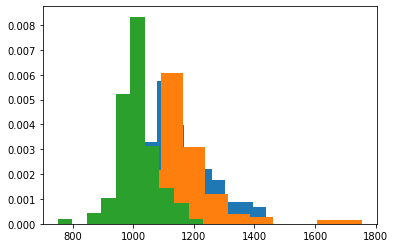

In [191]:
plt.hist(net_worths_train, density = True)
plt.hist(net_worths_test, density = True)
plt.hist(net_worths_rand, density = True)

In [192]:
np.mean(net_worths_train)

1166.3440142007469

In [193]:
np.mean(net_worths_rand)

1014.2416272403601

In [194]:
np.mean(net_worths_test)

1171.9707186620672

In [48]:
trade_env = TradeEnv(tickers=tickers, path = 'test_day.csv')

bh_nws = []
for j in range(len(tickers) + 1):
    nws = []

    for i in range(100):
        INITIAL_BALANCE = 1000.0
        done = False
        obs = trade_env.reset()
        while not done:
            #action = model.predict(obs, deterministic = True)[0]
            action = -10*np.ones(6)
            action[j] = 10
            obs, _, done, _ = trade_env.step(action)
        nws.append(trade_env.net_worth)
    bh_nws.append(nws)


In [49]:
for bhn in bh_nws:
    print (np.mean(bhn))

1003.3555318514889
1003.5135475228999
1004.8944073042595
1008.8604851833978
1004.8972773586585
1000.0000000536487


In [61]:
init_i = 40
irange = range(init_i, init_i + 30)

In [62]:
trade_env = TradeEnv(tickers=tickers, path = 'train_day.csv')

net_worths_train = []




INITIAL_BALANCE = 1000.0
for i in range(init_i, init_i + 30):
    done = False
    obs = trade_env.reset(i*30)
    while not done:
        action = model.predict(obs, deterministic = True)[0]
        obs, _, done, _ = trade_env.step(action)
    INITIAL_BALANCE = trade_env.net_worth
print (trade_env.net_worth)

1384.3488473089108


In [73]:
trade_env = TradeEnv(tickers=tickers, path = 'test_day.csv')

net_worths_train = []



INITIAL_BALANCE = 1000.0
for i in irange:
    done = False
    obs = trade_env.reset(i*30)
    while not done:
        action = model.predict(obs, deterministic = True)[0]
        obs, _, done, _ = trade_env.step(action)
    INITIAL_BALANCE = trade_env.net_worth
print (trade_env.net_worth)

1229.7324640956117


In [74]:
trade_env = TradeEnv(tickers=tickers, path = 'test_day.csv')

net_worths_train = []



INITIAL_BALANCE = 1000.0
for i in irange:
    done = False
    obs = trade_env.reset(i*30)
    while not done:
        #action = model.predict(obs, deterministic = False)[0]
        action = -10*np.zeros(6)
        action[4] = 10
        action = np.random.normal(size = 6)
        obs, _, done, _ = trade_env.step(action)
    INITIAL_BALANCE = trade_env.net_worth
print (trade_env.net_worth)

1098.0057705523154
